<a href="https://colab.research.google.com/github/Lucia-Garcia-Lado/Graph-Coloring-Models-for-Production-Line-Scheduling-Optimization/blob/main/graph_coloring_scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Coloring Models for Production Line Scheduling Optimization

> Lucía García Lado <br>
> Alejandro Sosa Corral

In [72]:
!pip install deap -q

In [73]:
from deap import base, creator, tools, algorithms
import random
import math

In [74]:
# ------------------------------------------------------------
# 1. Carga de datos para dataset JSPLIB
# ------------------------------------------------------------

def load_instance(filename):
    operations = []

    with open(filename, 'r') as f:
        # Leemos las líneas, ignorando comentarios (#)
        lines = [line.strip() for line in f if line.strip() and not line.startswith("#")]

    # Eliminamos el header y tomamos el número de trabajos y máquinas
    header = lines[0].split()
    num_jobs = int(header[0])
    num_machines = int(header[1])

    # El resto de las líneas son trabajos
    job_lines = lines[1:]

    if len(job_lines) < num_jobs:
        raise ValueError(f"File format error: Expected {num_jobs} job lines, found {len(job_lines)}")

    for job_id in range(num_jobs):
        line = job_lines[job_id]
        values = list(map(int, line.split()))

        # Emparejamos: (Máquina, Duración)
        order = 0
        for i in range(0, len(values), 2):
            machine = values[i]
            duration = values[i+1]

            operations.append({
                "job": job_id,
                "machine": machine,
                "duration": duration,
                "order": order
            })
            order += 1

    return operations, num_jobs, num_machines

In [75]:
# ------------------------------------------------------------
# 2. Problema e hiperparámetros
# ------------------------------------------------------------

OPERATIONS, NUM_JOBS, NUM_MACHINES = load_instance("ft10")
NUM_OPS = len(OPERATIONS)

HORIZON = sum(op["duration"] for op in OPERATIONS)

print(f"Dataset loaded. Horizon set to: {HORIZON}")

# Variables genéticas
POPULATION_SIZE = max(NUM_OPS*15, 200)
NUM_GENERATIONS = NUM_OPS*5
CROSS_PROBABILITY = 0.8
MUT_PROBABILITY = 0.2

TOURNAMENT_SIZE = 2
ELITE_SIZE = 5

START_SHIFT = int(HORIZON*0.7)
END_SHIFT = 1

Dataset loaded. Horizon set to: 5109


In [76]:
# 1. Mapa ID Máquina -> Lista de (índice, operación)
MACHINE_MAP = {}
machine_ids = set(op["machine"] for op in OPERATIONS)
for m in machine_ids:
    MACHINE_MAP[m] = [(i, op) for i, op in enumerate(OPERATIONS) if op["machine"] == m]

# 2. Mapa ID Trabajo -> Lista de (índice, operación) ordenadas por secuencia
JOB_MAP = {}
job_ids = set(op["job"] for op in OPERATIONS)
for j in job_ids:
    ops = [(i, op) for i, op in enumerate(OPERATIONS) if op["job"] == j]
    ops.sort(key=lambda x: x[1]["order"])
    JOB_MAP[j] = ops

# ------------------------------------------------------------
# 3. Función de Fitness (Evaluación)
# ------------------------------------------------------------

def evaluate(ind):
    # --- CONFLICTOS DE MÁQUINA ---
    machine_conflicts = 0

    for machine_id, machine_ops in MACHINE_MAP.items():

        # Comparamos cada par de operaciones en la misma máquina
        for i in range(len(machine_ops)):
            for j in range(i + 1, len(machine_ops)):

                index_A, op_data_A = machine_ops[i]
                index_B, op_data_B = machine_ops[j]

                start_A = ind[index_A]
                end_A = start_A + op_data_A["duration"]

                start_B = ind[index_B]
                end_B = start_B + op_data_B["duration"]

                # Comprobamos el overlap
                if start_A < end_B and start_B < end_A:
                    machine_conflicts += 1

    # --- CONFLICTOS DE PRECEDENCIA ---
    precedence_conflicts = 0

    for job_id, job_steps in JOB_MAP.items():

        # Iteramos sobre los pasos secuenciales
        for k in range(len(job_steps) - 1):
            current_step_idx, current_step_data = job_steps[k]
            next_step_idx, next_step_data = job_steps[k+1]

            current_step_end_time = ind[current_step_idx] + current_step_data["duration"]
            next_step_start_time = ind[next_step_idx]

            # El siguiente paso no puede empezar antes de que termine el actual
            if next_step_start_time < current_step_end_time:
                precedence_conflicts += 1

    # --- OBJETIVOS ---
    end_times = [ind[i] + OPERATIONS[i]["duration"] for i in range(NUM_OPS)]
    Cmax = max(end_times) if end_times else 0

    # Energía (Peak Load)
    events = []
    for i in range(NUM_OPS):
        start = ind[i]
        end = start + OPERATIONS[i]["duration"]
        events.append((start, 1))   # Máquina ON
        events.append((end, -1))    # Máquina OFF

    events.sort()

    peak_load = 0
    current_load = 0
    for _, change in events:
        current_load += change
        if current_load > peak_load:
            peak_load = current_load

    energy = peak_load

    # --- SUMA PONDERADA ---
    alpha = 1000  # Penalización alta por conflicto de máquina
    beta = 1000   # Penalización alta por conflicto de precedencia
    gamma = 10    # Peso para Carga Pico
    delta = 0.1   # Peso para Makespan

    total_cost = (alpha * machine_conflicts) + \
                 (beta * precedence_conflicts) + \
                 (gamma * energy) + \
                 (delta * Cmax)

    return total_cost,

In [77]:
# ------------------------------------------------------------
# 4. Operadores Genéticos
# ------------------------------------------------------------

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Generación de individuos factibles
def generate_feasible_sequence():
    ind = [0] * NUM_OPS

    start_range = int(HORIZON * 0.3)
    if start_range < 1: start_range = 1

    slack_range = int(HORIZON * 0.05)
    if slack_range < 1: slack_range = 1

    for job_id, steps in JOB_MAP.items():

        current_time = random.randint(0, start_range)

        for idx, op_data in steps:
            # Asignamos el tiempo actual a este paso
            ind[idx] = current_time

            duration = op_data["duration"]

            # Calculamos cuándo debe empezar el SIGUIENTE paso (Fin del actual + un "Slack" aleatorio (hueco)).
            slack = random.randint(0, slack_range)
            current_time += duration + slack

            if current_time > HORIZON:
                current_time = HORIZON

    return creator.Individual(ind)

# Generación de población
toolbox.register("individual", generate_feasible_sequence)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operadores estándar
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
toolbox.register("mate", tools.cxTwoPoint)

def multi_shift_mutation(ind, max_shift, indpb):  # Multi-shift nos permite explorar de manera más eficiente que el shift normal
    did_mutate = False
    for i in range(len(ind)):
        if random.random() < indpb:
            ind[i] += random.randint(-max_shift, max_shift)
            ind[i] = max(0, min(HORIZON, ind[i]))
            did_mutate = True

    if not did_mutate:
        idx = random.randrange(NUM_OPS)
        ind[idx] += random.randint(-max_shift, max_shift)
        # Mantener dentro de los límites válidos [0, HORIZON]
        ind[idx] = max(0, min(HORIZON, ind[idx]))
    return ind,

toolbox.register("mutate", multi_shift_mutation, max_shift=20, indpb=0.1)

/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [78]:
import matplotlib.pyplot as plt

def main():
    pop = toolbox.population(n=POPULATION_SIZE)

    # Evaluamos la población inicial
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    print(f"Iniciando evolución... (Horizonte={HORIZON}, Pob={POPULATION_SIZE})")

    # Listas para guardar estadísticas
    best_per_gen = []
    mean_per_gen = []
    gens = []

    for gen in range(NUM_GENERATIONS):

        # Calculamos progreso para shift variable
        progress = gen / NUM_GENERATIONS
        current_max_shift = int(START_SHIFT * (1 - progress) + END_SHIFT * progress)

        toolbox.register("mutate", multi_shift_mutation, max_shift=current_max_shift, indpb=0.1)

        # Generar descendencia
        offspring = algorithms.varAnd(pop, toolbox, CROSS_PROBABILITY, MUT_PROBABILITY)

        # Evaluar descendencia
        for ind in offspring:
            ind.fitness.values = toolbox.evaluate(ind)

        # ELITISMO: mantenemos los mejores padres
        elite = tools.selBest(pop, ELITE_SIZE)

        # Seleccionar el resto de la población desde la descendencia
        rest = toolbox.select(offspring, POPULATION_SIZE - ELITE_SIZE)

        # Nueva población = élite + seleccionados del offspring
        pop = elite + rest

        # Estadísticas de esta generación
        best = tools.selBest(pop, k=1)[0]
        best_cost = best.fitness.values[0]
        mean_cost = sum(ind.fitness.values[0] for ind in pop) / len(pop)

        best_per_gen.append(best_cost)
        mean_per_gen.append(mean_cost)
        gens.append(gen)

        # Imprimimos solo cada 10 generaciones para evitar llenar la consola
        if gen % 10 == 0:
            print(f"Gen {gen:3d} | Mejor coste: {best_cost:.2f} | "
                  f"Media: {mean_cost:.2f} | Shift actual: {current_max_shift}")

    # Resultados Finales
    best_final = tools.selBest(pop, k=1)[0]
    print("\n--- Resultado Final ---")
    print(f"Mejor coste: {best_final.fitness.values[0]:.2f}")
    print(f"Horario (Start Times): {best_final}")

    cost_val = best_final.fitness.values[0]
    if cost_val < 1000:
        print("La solución es FACTIBLE")
    else:
        print("La solución es INFACTIBLE (Penalizaciones > 0)")

    # 👇 Gráfica de mejor y media por generación
    plt.figure(figsize=(10, 5))
    plt.plot(gens, best_per_gen, label="Mejor fitness")
    plt.plot(gens, mean_per_gen, label="Media fitness")
    plt.xlabel("Generación")
    plt.ylabel("Coste (fitness)")
    plt.title("Evolución del algoritmo genético")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Iniciando evolución... (Horizonte=5109, Pob=1500)
Gen   0 | Mejor coste: 8364.80 | Media: 20135.22 | Shift actual: 3576


KeyboardInterrupt: 

# Multiobejtivo

In [ ]:
# ------------------------------------------------------------
# 2. Problema e hiperparámetros
# ------------------------------------------------------------

OPERATIONS, NUM_JOBS, NUM_MACHINES = load_instance("ft10")
NUM_OPS = len(OPERATIONS)

HORIZON = sum(op["duration"] for op in OPERATIONS)

print(f"Dataset loaded. Horizon set to: {HORIZON}")

# Variables genéticas
POPULATION_SIZE = max(NUM_OPS*15, 200)
NUM_GENERATIONS = 500
CROSS_PROBABILITY = 0.8
MUT_PROBABILITY = 0.2

ELITE_SIZE = 5

START_SHIFT = int(HORIZON*1.2)
END_SHIFT = 1

In [ ]:
# 1. Mapa ID Máquina -> Lista de (índice, operación)
MACHINE_MAP = {}
machine_ids = set(op["machine"] for op in OPERATIONS)
for m in machine_ids:
    MACHINE_MAP[m] = [(i, op) for i, op in enumerate(OPERATIONS) if op["machine"] == m]

# 2. Mapa ID Trabajo -> Lista de (índice, operación) ordenadas por secuencia
JOB_MAP = {}
job_ids = set(op["job"] for op in OPERATIONS)
for j in job_ids:
    ops = [(i, op) for i, op in enumerate(OPERATIONS) if op["job"] == j]
    ops.sort(key=lambda x: x[1]["order"])
    JOB_MAP[j] = ops

# ------------------------------------------------------------
# 3. Función de Fitness (Evaluación)
# ------------------------------------------------------------

def evaluate(ind):
    # --- CONFLICTOS DE MÁQUINA ---
    machine_conflicts = 0

    for machine_id, machine_ops in MACHINE_MAP.items():

        # Comparamos cada par de operaciones en la misma máquina
        for i in range(len(machine_ops)):
            for j in range(i + 1, len(machine_ops)):

                index_A, op_data_A = machine_ops[i]
                index_B, op_data_B = machine_ops[j]

                start_A = ind[index_A]
                end_A = start_A + op_data_A["duration"]

                start_B = ind[index_B]
                end_B = start_B + op_data_B["duration"]

                # Comprobamos el overlap
                if start_A < end_B and start_B < end_A:
                    machine_conflicts += 1

    # --- CONFLICTOS DE PRECEDENCIA ---
    precedence_conflicts = 0

    for job_id, job_steps in JOB_MAP.items():

        # Iteramos sobre los pasos secuenciales
        for k in range(len(job_steps) - 1):
            current_step_idx, current_step_data = job_steps[k]
            next_step_idx, next_step_data = job_steps[k+1]

            current_step_end_time = ind[current_step_idx] + current_step_data["duration"]
            next_step_start_time = ind[next_step_idx]

            # El siguiente paso no puede empezar antes de que termine el actual
            if next_step_start_time < current_step_end_time:
                precedence_conflicts += 1

    # --- OBJETIVOS ---
    end_times = [ind[i] + OPERATIONS[i]["duration"] for i in range(NUM_OPS)]
    Cmax = max(end_times) if end_times else 0

    # Energía (Peak Load)
    events = []
    for i in range(NUM_OPS):
        start = ind[i]
        end = start + OPERATIONS[i]["duration"]
        events.append((start, 1))   # Máquina ON
        events.append((end, -1))    # Máquina OFF

    events.sort()

    peak_load = 0
    current_load = 0
    for _, change in events:
        current_load += change
        if current_load > peak_load:
            peak_load = current_load

    energy = peak_load

    gamma = 10    # Peso para Carga Pico
    delta = 0.1

    return energy*gamma+Cmax*delta, ((machine_conflicts+precedence_conflicts)**2)*1000

In [ ]:
# ------------------------------------------------------------
# 4. Operadores Genéticos
# ------------------------------------------------------------

creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -10.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)


toolbox = base.Toolbox()

# Generación de individuos factibles
def generate_feasible_sequence():
    ind = [0] * NUM_OPS

    start_range = int(HORIZON * 0.1)
    if start_range < 1: start_range = 1

    slack_range = int(HORIZON * 0.20)
    if slack_range < 1: slack_range = 1

    for job_id, steps in JOB_MAP.items():

        current_time = random.randint(0, start_range)

        for idx, op_data in steps:
            # Asignamos el tiempo actual a este paso
            ind[idx] = current_time

            duration = op_data["duration"]

            # Calculamos cuándo debe empezar el SIGUIENTE paso (Fin del actual + un "Slack" aleatorio (hueco)).
            slack = random.randint(0, slack_range)
            current_time += duration + slack

            if current_time > HORIZON:
                current_time = HORIZON

    return creator.Individual(ind)

# Generación de población
toolbox.register("individual", generate_feasible_sequence)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operadores estándar
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", tools.cxTwoPoint)

def multi_shift_mutation(ind, max_shift, indpb):  # Multi-shift nos permite explorar de manera más eficiente que el shift normal
    did_mutate = False
    for i in range(len(ind)):
        if random.random() < indpb:
            ind[i] += random.randint(-max_shift, max_shift)
            ind[i] = max(0, min(HORIZON, ind[i]))
            did_mutate = True

    if not did_mutate:
        idx = random.randrange(NUM_OPS)
        ind[idx] += random.randint(-max_shift, max_shift)
        # Mantener dentro de los límites válidos [0, HORIZON]
        ind[idx] = max(0, min(HORIZON, ind[idx]))
    return ind,

toolbox.register("mutate", multi_shift_mutation, max_shift=20, indpb=0.1)

In [ ]:
def main():

    pop = toolbox.population(n=POPULATION_SIZE)

    # Evaluar población inicial
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    # NSGA-II requiere ordenar la población inicial
    pop = toolbox.select(pop, len(pop))

    print(f"Iniciando evolución... (Horizonte={HORIZON}, Pob={POPULATION_SIZE})")

    for gen in range(NUM_GENERATIONS):

        progress = gen/NUM_GENERATIONS
        current_max_shift = int(START_SHIFT * (1 - progress) + END_SHIFT * progress)

        toolbox.register("mutate", multi_shift_mutation, max_shift=current_max_shift, indpb=0.1)

        # Crear descendencia
        offspring = algorithms.varAnd(pop, toolbox, CROSS_PROBABILITY, MUT_PROBABILITY)

        # Evaluar descendencia
        for ind in offspring:
            ind.fitness.values = toolbox.evaluate(ind)

        # --- ELITISMO PARA MULTIOBJETIVO ---
        ELITE_SIZE = 5
        elite = tools.selNSGA2(pop, ELITE_SIZE)

        # Unimos élite + descendencia
        combined = elite + offspring

        # Selección NSGA-II del total (ordena por Pareto + crowding)
        pop = tools.selNSGA2(combined, POPULATION_SIZE)

        # El mejor según sort NSGA-II (primer front y mayor crowding)
        best = pop[0]

        if gen % 10 == 0:
            print(
                f"Gen {gen:3d} | Objetivos: {best.fitness.values} | Shift actual: {current_max_shift}"
            )

    # ==============================
    #  Resultados finales
    # ==============================
    best_final = pop[0]
    print("\n--- Resultado Final ---")
    print(f"Mejores objetivos (energy, 0.1*Cmax, penalización): {best_final.fitness.values}")
    print(f"Horario (Start Times): {best_final}")

    # ==============================
    #  Frente de Pareto
    # ==============================
    fronts = tools.sortNondominated(pop, k=len(pop), first_front_only=True)
    pareto_front = fronts[0]

    pareto_feasible = [ind for ind in pareto_front if ind.fitness.values[1] == 0]
    pareto_infeasible = [ind for ind in pareto_front if ind.fitness.values[1] != 0]

    if pareto_feasible:
        pf_to_plot = pareto_feasible
        print(f"Soluciones en el frente de Pareto factibles: {len(pareto_feasible)}")
    else:
        pf_to_plot = pareto_front
        print("⚠ No hay soluciones factibles en el frente de Pareto. Se grafican todas.")

    x_vals = [ind.fitness.values[0] for ind in pf_to_plot]
    y_vals = [ind.fitness.values[1] for ind in pf_to_plot]

    plt.figure(figsize=(7, 5))
    plt.scatter(x_vals, y_vals)
    plt.xlabel("Energy (peak load)")
    plt.ylabel("0.1 * Cmax")
    plt.title("Frente de Pareto (NSGA-II)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
  main()


Iter      0 | T=1999.8000 | coste actual=32350.60 | mejor=32350.60
Iter   1000 | T=1809.4848 | coste actual=31352.00 | mejor=27350.70
Iter   2000 | T=1637.2814 | coste actual=28354.30 | mejor=26354.30
Iter   3000 | T=1481.4661 | coste actual=30356.50 | mejor=26354.30
Iter   4000 | T=1340.4792 | coste actual=28356.00 | mejor=24356.20
Iter   5000 | T=1212.9097 | coste actual=29357.20 | mejor=24356.20
Iter   6000 | T=1097.4806 | coste actual=26367.70 | mejor=24356.20
Iter   7000 | T=993.0365 | coste actual=24367.50 | mejor=23366.90
Iter   8000 | T=898.5321 | coste actual=25367.80 | mejor=20357.70
Iter   9000 | T=813.0214 | coste actual=22359.70 | mejor=20357.70
Iter  10000 | T=735.6485 | coste actual=22357.90 | mejor=17357.90
Iter  11000 | T=665.6390 | coste actual=22367.90 | mejor=17357.90
Iter  12000 | T=602.2920 | coste actual=17370.50 | mejor=17357.90
Iter  13000 | T=544.9737 | coste actual=17358.10 | mejor=16360.20
Iter  14000 | T=493.1101 | coste actual=18358.00 | mejor=16360.20
Ite

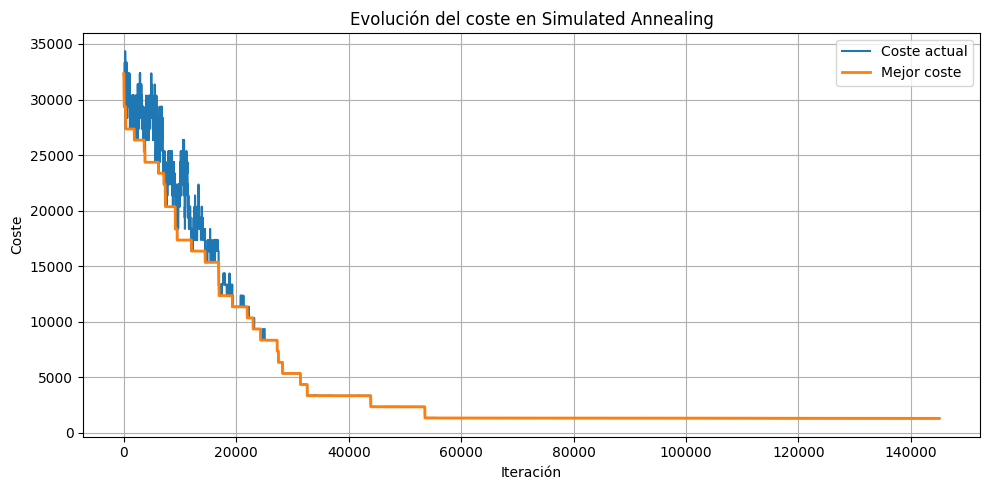

In [99]:
import math
import random
import matplotlib.pyplot as plt

# ============================================================
#  Evaluación (coste escalar) + función auxiliar de componentes
# ============================================================

def evaluate_components(ind):
    """
    Devuelve los componentes de la evaluación sin ponderar:
        - machine_conflicts
        - precedence_conflicts
        - Cmax
        - energy (peak_load)
    """
    # --- CONFLICTOS DE MÁQUINA ---
    machine_conflicts = 0

    for machine_id, machine_ops in MACHINE_MAP.items():

        # Comparamos cada par de operaciones en la misma máquina
        for i in range(len(machine_ops)):
            for j in range(i + 1, len(machine_ops)):

                index_A, op_data_A = machine_ops[i]
                index_B, op_data_B = machine_ops[j]

                start_A = ind[index_A]
                end_A = start_A + op_data_A["duration"]

                start_B = ind[index_B]
                end_B = start_B + op_data_B["duration"]

                # Comprobamos el overlap
                if start_A < end_B and start_B < end_A:
                    machine_conflicts += 1

    # --- CONFLICTOS DE PRECEDENCIA ---
    precedence_conflicts = 0

    for job_id, job_steps in JOB_MAP.items():

        # Iteramos sobre los pasos secuenciales
        for k in range(len(job_steps) - 1):
            current_step_idx, current_step_data = job_steps[k]
            next_step_idx, next_step_data = job_steps[k+1]

            current_step_end_time = ind[current_step_idx] + current_step_data["duration"]
            next_step_start_time = ind[next_step_idx]

            # El siguiente paso no puede empezar antes de que termine el actual
            if next_step_start_time < current_step_end_time:
                precedence_conflicts += 1

    # --- OBJETIVOS ---
    end_times = [ind[i] + OPERATIONS[i]["duration"] for i in range(NUM_OPS)]
    Cmax = max(end_times) if end_times else 0

    # Energía (Peak Load)
    events = []
    for i in range(NUM_OPS):
        start = ind[i]
        end = start + OPERATIONS[i]["duration"]
        events.append((start, 1))   # Máquina ON
        events.append((end, -1))    # Máquina OFF

    events.sort()

    peak_load = 0
    current_load = 0
    for _, change in events:
        current_load += change
        if current_load > peak_load:
            peak_load = current_load

    energy = peak_load

    return machine_conflicts, precedence_conflicts, Cmax, energy


def evaluate(ind):
    """
    MISMA función que has puesto: devuelve SOLO el coste escalar.
    Internamente reutiliza evaluate_components para no duplicar lógica.
    """
    machine_conflicts, precedence_conflicts, Cmax, energy = evaluate_components(ind)

    # --- SUMA PONDERADA ---
    alpha = 1000  # Penalización alta por conflicto de máquina
    beta  = 1000  # Penalización alta por conflicto de precedencia
    gamma = 10    # Peso para Carga Pico
    delta = 0.1   # Peso para Makespan

    total_cost = (alpha * machine_conflicts) + \
                 (beta  * precedence_conflicts) + \
                 (gamma * energy) + \
                 (delta * Cmax)

    return total_cost


# ============================================================
#  Movimiento (vecino)
# ============================================================

def move(ind, max_shift=20):
    """
    Genera un vecino modificando ligeramente algunos tiempos de inicio.
    - Se copia el individuo.
    - Se seleccionan una o varias posiciones y se les aplica un desplazamiento
      aleatorio en [-max_shift, max_shift].
    """
    new = ind[:]  # copia superficial suficiente (lista de ints)

    # Número de operaciones a alterar (al menos 1)
    num_changes = random.randint(1, max(1, len(new) // 10))

    for _ in range(num_changes):
        idx = random.randrange(len(new))
        shift = random.randint(-max_shift, max_shift)
        new[idx] = max(0, min(HORIZON, new[idx] + shift))

    return new


# ============================================================
#  Simulated Annealing
# ============================================================

def simulated_annealing(
    max_iters=50000,
    T_init=1000.0,
    T_min=1e-3,
    alpha=0.995,
    max_shift=20,
    verbose=True
):
    """
    Algoritmo de Recocido Simulado (Simulated Annealing) para el job-shop.

    - max_iters: número máximo de iteraciones.
    - T_init: temperatura inicial.
    - T_min: temperatura mínima (criterio de parada).
    - alpha: factor de enfriamiento (T = alpha * T).
    - max_shift: desplazamiento máximo para generar vecinos.
    """

    # ===== 1. Solución inicial (factible-ish) usando tu generador =====
    current = generate_feasible_sequence()
    current_cost = evaluate(current)

    best = current[:]
    best_cost = current_cost

    T = T_init

    costs_history = []
    best_history = []

    for it in range(max_iters):
        if T < T_min:
            if verbose:
                print(f"Temperatura mínima alcanzada en iter {it}.")
            break

        # ===== 2. Generar vecino =====
        candidate = move(current, max_shift=max_shift)
        candidate_cost = evaluate(candidate)

        # ===== 3. Criterio de aceptación =====
        delta = candidate_cost - current_cost

        if delta < 0:
            # Mejor solución -> aceptamos siempre
            accept = True
        else:
            # Peor solución -> aceptamos con probabilidad exp(-delta / T)
            prob = math.exp(-delta / T) if T > 0 else 0
            accept = (random.random() < prob)

        if accept:
            current = candidate
            current_cost = candidate_cost

            # Actualizar mejor global
            if current_cost < best_cost:
                best = current[:]
                best_cost = current_cost

        # ===== 4. Enfriamiento =====
        T *= alpha

        # ===== 5. Guardar histórico para graficar =====
        costs_history.append(current_cost)
        best_history.append(best_cost)

        if verbose and it % 1000 == 0:
            print(f"Iter {it:6d} | T={T:8.4f} | coste actual={current_cost:.2f} | mejor={best_cost:.2f}")

    # ===== 6. Resultados finales =====
    mc, pc, Cmax, energy = evaluate_components(best)
    alpha_p = 1000
    beta_p  = 1000
    penalty = alpha_p * mc + beta_p * pc  # parte de penalización pura

    print("\n--- Resultado Simulated Annealing ---")
    print(f"Mejor coste escalar: {best_cost:.2f}")
    print(f"Conflictos máquina: {mc}")
    print(f"Conflictos precedencia: {pc}")
    print(f"Cmax: {Cmax}")
    print(f"Energía (peak load): {energy}")
    print(f"Penalización pura (alpha*mc + beta*pc): {penalty}")
    print("Solución FACTIBLE" if penalty == 0 else f"Solución INFACTIBLE (penalty={penalty})")

    # ===== 7. Gráfica de evolución del coste =====
    plt.figure(figsize=(10, 5))
    plt.plot(costs_history, label="Coste actual")
    plt.plot(best_history, label="Mejor coste", linewidth=2)
    plt.xlabel("Iteración")
    plt.ylabel("Coste")
    plt.title("Evolución del coste en Simulated Annealing")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best, best_cost


if __name__ == "__main__":
    # Ejemplo de llamada a SA (puedes tunear los parámetros):
    best_solution, best_cost = simulated_annealing(
        max_iters=10000000,
        T_init=2000.0,
        T_min=1e-3,
        alpha=0.9999,
        max_shift=3,
        verbose=True
    )
